<a href="https://colab.research.google.com/github/frasercrichton/fastai2-learning/blob/feature%2Fstep-by-step/nbs/drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drone Tutorial

## Setup the Virtual Machine
 


Install stuff . . .

In [12]:
%matplotlib inline
bs = 64     # default batch size
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai2 -q
!pip install utils
from utils import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  21064      0 --:--:-- --:--:-- --:--:-- 21064
OK
54 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.30.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.
Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Data

All the images to running training on are held in GCP. This bit connects to the GCP Bucket and mounts it so we can use it.

In [13]:
from google.colab import auth
auth.authenticate_user()

In [14]:
!mkdir forensic-architecture-machine-learning
!gcsfuse -o nonempty --implicit-dirs forensic-architecture-machine-learning forensic-architecture-machine-learning

mkdir: cannot create directory ‘forensic-architecture-machine-learning’: File exists
Using mount point: /content/forensic-architecture-machine-learning
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [ ]:
# path = Path('forensic-architecture-machine-learning/drone/'); path


In [21]:
path = untar_data("https://storage.googleapis.com/forensic-architecture-machine-learning/drone/drones.zip"); path

Path('/root/.fastai/data/drones')

Get that dataset

In [22]:
from fastai2.vision.all import *
dataset = path/'dataset'; dataset
dataset.ls()

(#39) [Path('/root/.fastai/data/drones/dataset/CQ-10_Snowgoose.log'),Path('/root/.fastai/data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout'),Path('/root/.fastai/data/drones/dataset/RQ-21_Blackjack.log'),Path('/root/.fastai/data/drones/dataset/MQ-19_Aerosonde.log'),Path('/root/.fastai/data/drones/dataset/MQ-9_Reaper.log'),Path('/root/.fastai/data/drones/dataset/Switchblade'),Path('/root/.fastai/data/drones/dataset/Snipe'),Path('/root/.fastai/data/drones/dataset/RQ-11_Raven.log'),Path('/root/.fastai/data/drones/dataset/Black_Hornet_Nano'),Path('/root/.fastai/data/drones/dataset/RQ-12_Wasp.log')...]

In [23]:
Path.BASE_PATH = path # display all paths relative to dataset root
path.ls()

(#1) [Path('dataset')]

Populate an Image data loader and then check we can see some drones in there.

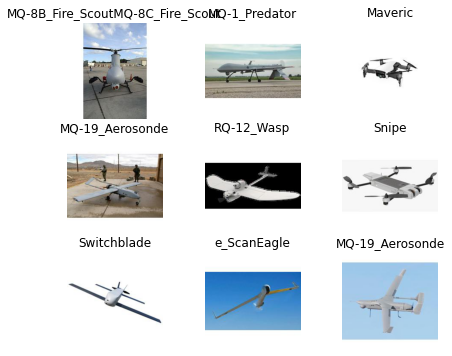

In [24]:
path_img = path/'dataset'
fnames = get_image_files(path_img)
# fnames = get_image_files(path)
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(path, fnames, label_func)
# , item_tfms=Resize(460), bs=bs, batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls.show_batch(max_n=9, figsize=(7,6))

In [25]:
print(dls.vocab)
len(dls.vocab),dls.c

(#12) ['MQ-19_Aerosonde','MQ-1_Predator','MQ-8B_Fire_ScoutMQ-8C_Fire_Scout','Maveric','RQ-12_Wasp','RQ-21_Blackjack','RQ-4_Global_Hawk','RQ-7_Shadow','Snipe','Stalker'...]


(12, 12)


## Images 

The images for the project are held in Google Drive and can be mounted below.

In [26]:
path_img = path/'dataset'
fnames = get_image_files(path_img)
fnames

(#181) [Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000015.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000014.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000004.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000011.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000018.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000003.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000019.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000020.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000007.jpg'),Path('dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000005.jpg')...]

Train that model. 

In [33]:
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.867470,4.353140,0.833333,00:01
1,3.884562,3.691072,0.805556,00:01
2,3.959062,3.359155,0.805556,00:01
3,3.932768,3.051589,0.777778,00:01
4,3.735480,2.533303,0.694444,00:01
5,3.436740,2.185859,0.638889,00:01
6,3.123151,2.018346,0.500000,00:01
7,2.822439,1.970392,0.527778,00:01
8,2.580137,1.966146,0.527778,00:01
9,2.366629,1.968675,0.527778,00:01


In [34]:
learn.save('stage-1')

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

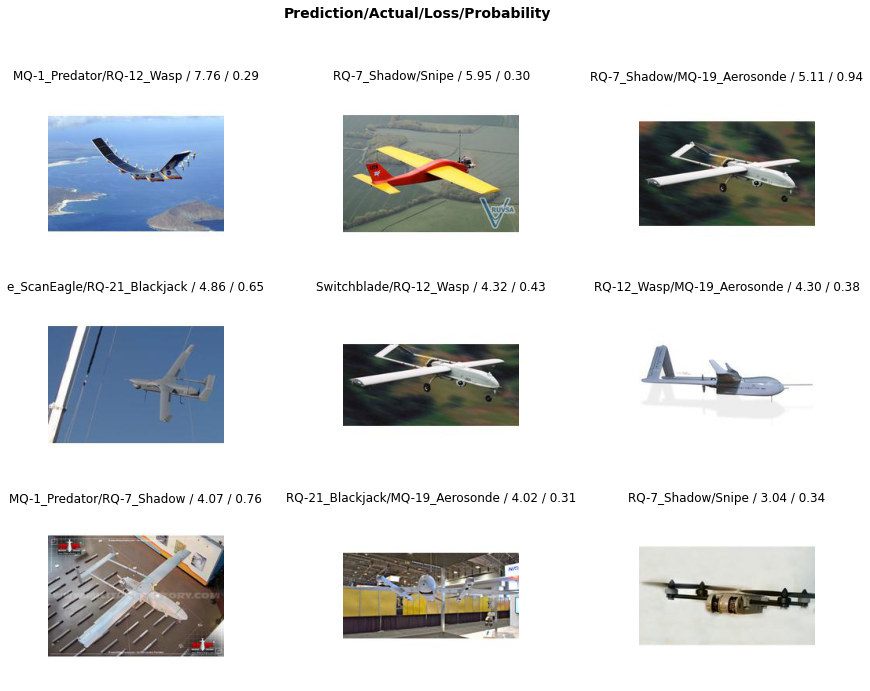

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

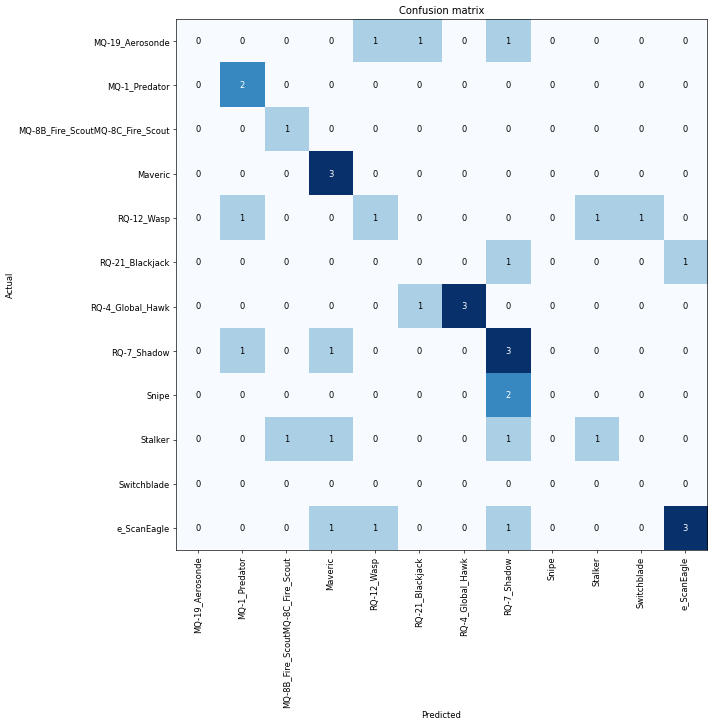

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

And everything appears confused for now:

In [32]:
interp.most_confused(min_val=2)

[('Maveric', 'MQ-19_Aerosonde', 2),
 ('RQ-12_Wasp', 'MQ-19_Aerosonde', 2),
 ('RQ-4_Global_Hawk', 'MQ-19_Aerosonde', 2),
 ('RQ-7_Shadow', 'MQ-19_Aerosonde', 2),
 ('e_ScanEagle', 'RQ-7_Shadow', 2)]